In [1]:
from manifold_learning import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand, get_truncated_rossler_lorenz_rand
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

In [423]:
ccm = CCM.FastCCM(device="cpu")

In [487]:
t = np.linspace(0,200,20000)
r = np.linspace(0.1,3.2,2000)
resX1X2 = []
resX2X1 = []
for i in r:
    X1 = np.array([np.sin(t), np.cos(t)]).T[None]
    X2 = np.array([np.sin(i*t+1), np.cos(i*t)]).T[None]
    resX1X2 += [ ccm.compute(X1,X2,9000,1000,50,20,0).mean() ]
    resX2X1 += [ ccm.compute(X2,X1,9000,1000,50,20,0).mean() ]

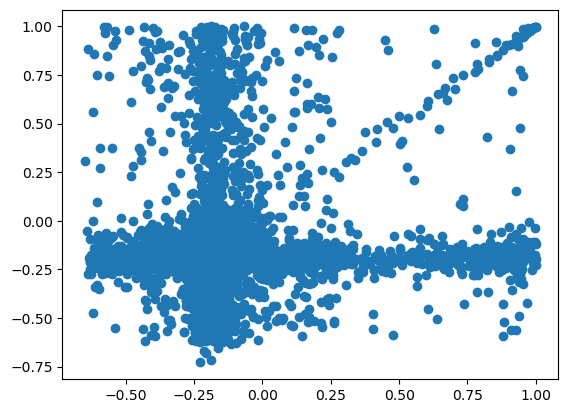

In [480]:
plt.scatter(resX1X2, resX2X1)

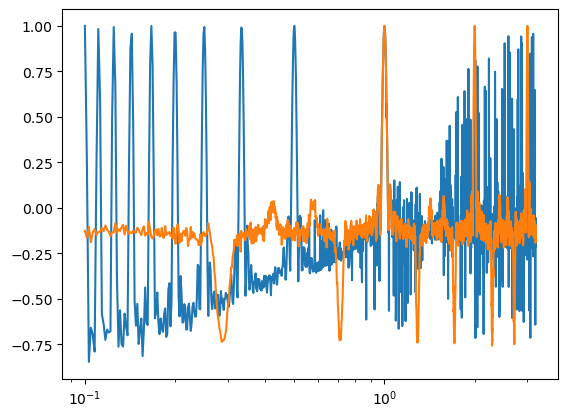

In [488]:
plt.plot(r,resX2X1)
plt.plot(r,resX1X2)
plt.xscale("log")

**CCM for joint Rossler-Lorenz attractor**

In [316]:
X = get_truncated_rossler_lorenz_rand(500,50000,alpha=4, C=2)

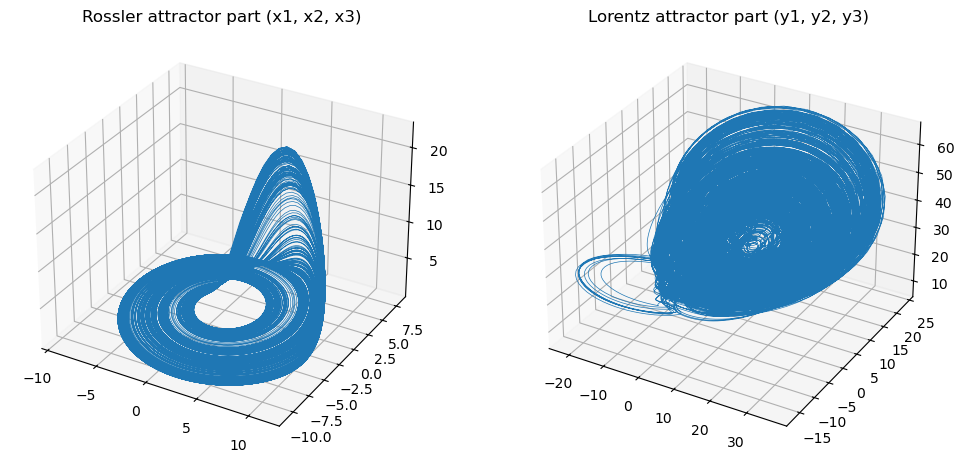

In [318]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(*X[:,[0, 1, 2]].T, lw=0.5)
ax1.set_title('Rossler attractor part (x1, x2, x3)')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(*X[:, [4, 3, 5]].T, lw=0.5)
ax2.set_title('Lorentz attractor part (y1, y2, y3)')

plt.show()

(non-time-delay-embedded) Lorenz xmap Rossler

In [319]:
ccm.compute(X[:,:3][None],X[:,3:][None],10000,1500,50,20,0).mean()

0.69421196

(non-time-delay-embedded) Rossler xmap Lorentz

In [320]:
ccm.compute(X[:,3:][None],X[:,:3][None],10000,1500,50,20,0).mean()

0.57190806

**5 independent Lorentz systems, each coordinate time delay embedded into 5 dimensions. All pairwise CCM.**

In [35]:
N_sys = 5

# Generate X axes of Lorenz systems starting from different initial state
X = np.concatenate([get_truncated_lorenz_rand(280,n_steps=30000).T for i in range(N_sys)])

X_emb = [utils.get_td_embedding_np(x[:,None],5,30,return_pred=False)[:,:,0] for x in X]

In [36]:
np.array(X_emb).shape

(15, 29880, 5)

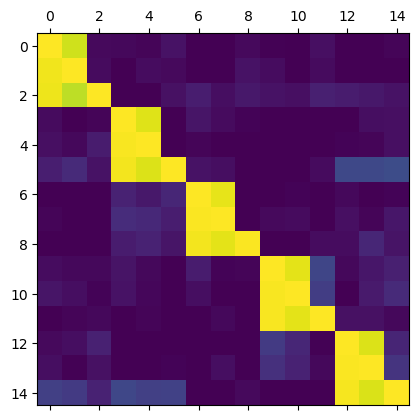

In [38]:
plt.matshow(ccm.compute(X_emb,X_emb,2000,500,30,5,0)[0],vmax=1,vmin=0)

**Finding a prediction power for a range of Tp**

In [66]:
X = get_truncated_lorenz_rand(280,n_steps=30000)[None]
Y = X[:,:,[0]]

In [67]:
X.shape, Y.shape

((1, 30000, 3), (1, 30000, 1))

The naive way

2.177140951156616 sec


Text(0, 0.5, 'Rho')

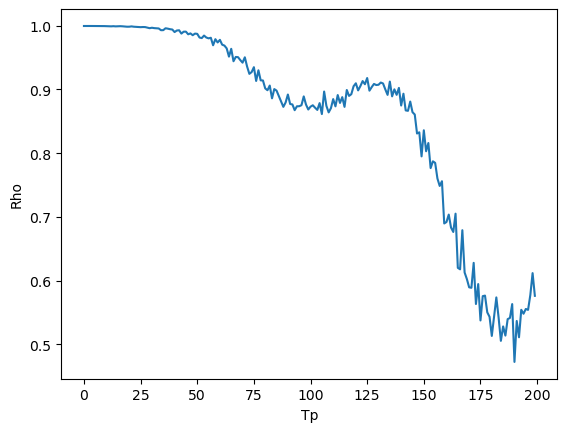

In [68]:
st = time.time()
res = [ccm.compute(X,Y,5000,1000,50,50,i)[0,0,0] for i in range(200)]
print(time.time()-st, "sec")
plt.plot(res)
plt.xlabel("Tp")
plt.ylabel("Rho")

The smart way

In [86]:
interval = 200
X_ = X[:,:-(interval-1)]
Y_ = utils.get_td_embedding_np(Y[0],interval,1)[:,:,0].T[:,:,None]
X_.shape, Y_.shape

((1, 29801, 3), (200, 29801, 1))

0.03505730628967285 sec


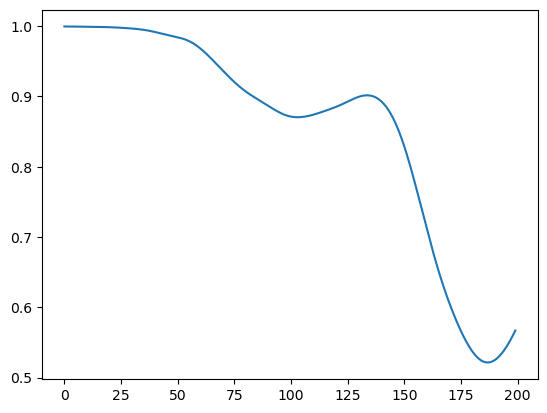

In [91]:
st = time.time()
res = ccm.compute(X_,Y_,5000,1000,50,50,0)[0,:,0]
print(time.time()-st, "sec")
plt.plot(res)

**Prediction horizon with different subset sizes**

In [35]:
exp_num = 20
tmax = 4000
n_steps = 200000
interval = 250
sample_size = 500
subset_sizes = np.arange(1000,50000,1000)

exp_res = []
for i in range(exp_num):
    X = get_truncated_lorenz_rand(tmax,n_steps=n_steps)[None]
    Y = X[:,:,[0]]

    X_ = X[:,:-(interval-1)]
    Y_ = utils.get_td_embedding_np(Y[0],interval,1)[:,:,0].T[:,:,None]
    X_ = utils.get_td_embedding_np(X_[0],3,2).reshape(-1,3*3)[None]

    res = np.array([ccm.compute(X_,Y_,i,sample_size,20,20,0)[0,:,0] for i in subset_sizes])
    exp_res += [res]
exp_res = np.array(exp_res).mean(axis=0)

/tmp/ipykernel_115411/3646813403.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', subset_sizes.shape[0])


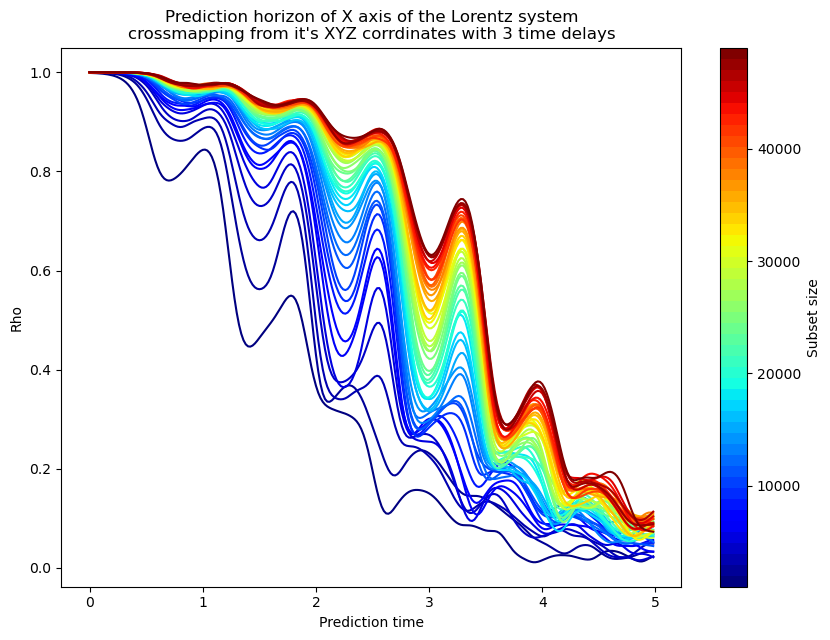

In [38]:
fig, ax = plt.subplots(figsize=(10, 7))
cmap = cm.get_cmap('jet', subset_sizes.shape[0])
norm = plt.Normalize(subset_sizes.min(), subset_sizes.max())

for i in range(exp_res.shape[0]):
    ax.plot(tmax/n_steps * np.arange(interval), exp_res[i], color=cmap(i))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Subset size')

ax.set_xlabel("Prediction time")
ax.set_ylabel("Rho")
plt.title("Prediction horizon of X axis of the Lorentz system\ncrossmapping from it's XYZ corrdinates with 3 time delays")
plt.show()

/tmp/ipykernel_115411/1696074535.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', subset_sizes.shape[0])


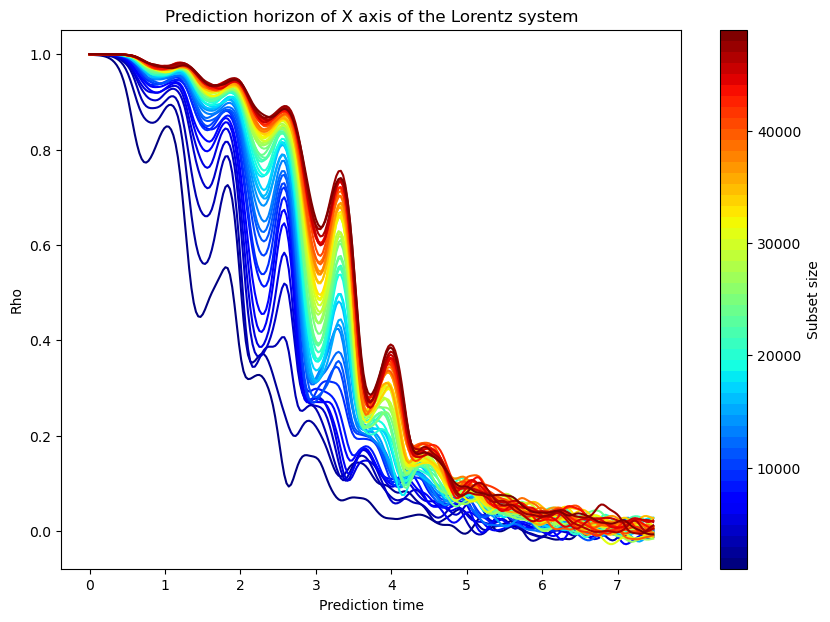

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
cmap = cm.get_cmap('jet', subset_sizes.shape[0])
norm = plt.Normalize(subset_sizes.min(), subset_sizes.max())

for i in range(exp_res.shape[0]):
    ax.plot(tmax/n_steps * np.arange(interval), exp_res[i], color=cmap(i))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Subset size')

ax.set_xlabel("Prediction time")
ax.set_ylabel("Rho")
plt.title("Prediction horizon of X axis of the Lorentz system")
plt.show()